# Consistency and tension
Aim: Determine the level of consistency between two datasets

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from chainconsumer import ChainConsumer
# Sampler
import pymultinest

In this tutorial we will work with some mock data resembling a cosmic shear measurement. In cosmic shear we measure the galaxy shapes in several tomographic redshift bins. From these measurements we calculate two-point statistics, from which we then constrain cosmological parameters. 

Here, we will work with one single redshift bins and pretend that we have two cosmic shear measurements in this bin. Our goal is to asses whether or not the two observations are consistent with each other and if there exists a model that provides a good fit to both datasets at the same time. For simplicity, we will not model the full cosmic shear power spectrum, but instead adopt a very simple model.

There are two sets of data in this directory (data_1.txt and data_2.txt). Each file contains three columns: 8 logarithmic $\ell$-values and two corresponding measurements of cosmic shear band power spectra $C_E$ for dataset A and B. As we will see later, the measurements in one file are consistent with each other while the other ones show some tension. For simplicity, we assume all measurements share the covariance matrix in covariance.txt.

In [3]:
# Read the data in data_1.txt and the covariance matrix in covariance_1.txt
ell, data_1A, data_1B = np.loadtxt('data_1.txt').T
ell, data_2A, data_2B = np.loadtxt('data_2.txt').T
covmat = np.loadtxt('covariance.txt')

Now, plot the two data vectors using matplotlib (including errorbars)

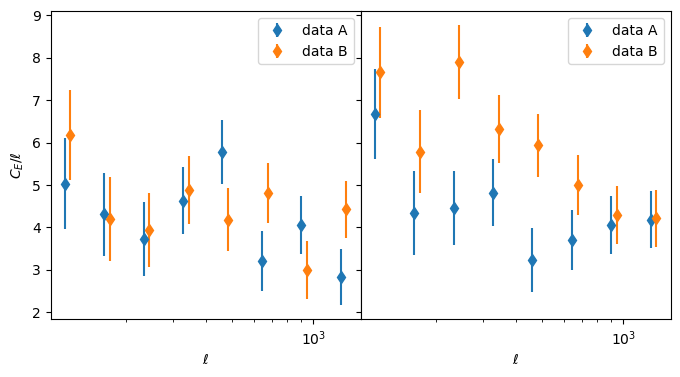

In [4]:
# Plot the two datavectors (note: plot ell vs data/ell for better visualisation)
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)
ax[0].errorbar(ell, data_1A/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C0', fmt='d', label = 'data A')
ax[0].errorbar(ell*1.05, data_1B/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C1', fmt='d', label = 'data B')
ax[0].set_xscale('log')
ax[0].legend()

ax[1].errorbar(ell, data_2A/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C0', fmt='d', label = 'data A')
ax[1].errorbar(ell*1.05, data_2B/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C1', fmt='d', label = 'data B')
ax[1].set_xscale('log')
ax[1].legend()

ax[0].set_ylabel('$C_E/\ell$')
ax[0].set_xlabel('$\ell$')
ax[1].set_xlabel('$\ell$')
plt.subplots_adjust(wspace=0)
plt.show()

Our goal is to fit a theory model to the two observed datasets and quantify the level of consistency between the two experiments. We will use MultiNest to sample the posterior and to infer the evidence.

In [5]:
# Define a linear model simple model 
def model(ell, a, b):
    return((b + ell*a)*1e-5)

MultiNest generates samples in a unit hyper-cube in which all the parameter are uniformly distributed in the interval [0, 1].
Therefore, we need to define a function that transforms the interval [0,1] onto our desired prior. Additionally, we need to define the likelihood function.

To get started, define a uniform prior in the interval [-2.5,9] for the amplitude and [0.022,0.055] for the tilt.

The MultiNest prior function and the likelihood function require three inputs: the MultiNest hypercube, the number of dimensions, and the number of parameters.
The number of parameters and the number of dimension are the same, unless we want to generate a set of derived parameters. 

The prior function should return the transformed hypercube and the likelihood function should return the log-likelihood.

In [6]:
# Define the prior function
# The prior function should use the following inputs:
# cube: A N-dimension array (where N is the number of model parameters). The entries of this array are the parameter values
#       generated by MultiNest during sampling. However, MultiNest generates its parameter values in the interval [0,1],
#       which is why we need to define a transformation onto our prior interval. 
# ndim: The number of model parameters
# nparams: The total number of parameters (which can be larger than the number of model parameters if we calculate
#          some derived parameters). In this tutorial this parameter will be equal to ndim.
# The output of the function should be the transformed N-dimensional array
def prior(cube, ndim, boundaries):
    # define a linear transformation from [0,1] to the prior interval
    for i in range(ndim):
        cube[i] = boundaries[i][0] + (boundaries[i][1]-boundaries[i][0])*cube[i]
    return(transformed_cube)

def prior_1(cube, ndim, nparams):
    return(prior(cube, ndim, [[-2,9],[0.021,0.057]]))

def prior_2(cube, ndim, nparams):
    return(prior(cube, ndim, [[-2,11],[0.022,0.055]]))
    
# Define the likelihood function (hint: use a Gaussian chi^2)
# The likelihood function should use the following inputs:
# cube: A N-dimensional array, which contains the values of our model parameters for a given point.
#       (Internally, MultiNest first generates parameters in the interval [0,1], which are passed to the prior 
#       function (defined above). The output of the prior function (i.e. the transformed parameter values) is then
#       passed to the likelihood function.
# ndim: same as above
# nparams: same as above

def log_lkl(cube, ndim, nparams, data):
    # Define a Gaussian log-likelihood with the data that you loaded from the text file
    diff = model(ell, cube[0], cube[1]) - data
    cholesky_transform = scipy.linalg.cholesky(covmat, lower=True)
    y = scipy.linalg.solve_triangular(cholesky_transform, diff, lower=True)
    chi2 = y.dot(y)
    # return the log-likelihood
    return(-0.5*chi2)

log_lkl_1A = lambda cube, ndim, nparams: log_lkl(cube, ndim, nparams, data_1A)
log_lkl_1B = lambda cube, ndim, nparams: log_lkl(cube, ndim, nparams, data_1B)

log_lkl_2A = lambda cube, ndim, nparams: log_lkl(cube, ndim, nparams, data_2A)
log_lkl_2B = lambda cube, ndim, nparams: log_lkl(cube, ndim, nparams, data_2B)

In [7]:
# MultiNest parameters
eff = 0.1
tol = 0.001
nLive = 1000
nDims = 2

In [9]:
# Sample the likelihood using multinest
# Hint: use pymultinest.run (you can run 'help(pymultinest.run)' to check how to run the sampler.
# MultiNest automatically saves some output files to disk. You need to set outputfiles_basename for each chain.

# IMPORTANT NOTE: If the output folder doesn't exist, MultiNest WILL CRASH! 
#                 Make sure to create output folder before running MultiNest!

# Additionally, MultiNest requires you to set the following parameters: n_live_points, sampling_efficiency, evidence_tolerance.
# Use the values provided in the cell above
pymultinest.run(log_lkl_1A, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1A', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_1B, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1B', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

pymultinest.run(log_lkl_2A, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_2A', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_2B, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_2B', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -7.7417629175227258      +/-   4.3665920910504086E-002
 Total Likelihood Evaluations:        84109
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -5.8783452612991978      +/-   4.2905475889259317E-002
 Total Likelihood Evaluations:        85053
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(

In [ ]:
pymultinest.run(log_lkl_1A, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1A',
                n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

Now plot the chains using chainconsumer

In [13]:
# Read the chains
# The chains contain 2+nparams columns: weight, -2*loglikehood, parameter values
# Hint: pymultinest.Analyzer allows you to access the MultiNest output. Alternatively, you can directly load the chain from outputfiles_basename.txt 
A1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_1A')
B1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_1B')
A2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_2A')
B2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_2B')
chain_1A = A1.get_data()
chain_1B = B1.get_data()
chain_2A = A2.get_data()
chain_2B = B2.get_data()

  analysing data from out_multinest/chain_1A.txt
  analysing data from out_multinest/chain_1B.txt
  analysing data from out_multinest/chain_2A.txt
  analysing data from out_multinest/chain_2B.txt


In [14]:
# To visualize the prior, run another chain with constant likelihood to generate samples from the prior
# Let's just set up a dummy likelihood function that just return a constant value.
# Run MultiNest with this sampler to generate a chain that resembles our prior.
def log_lkl_prior(cube, ndim, nparams):
    return(1)
pymultinest.run(log_lkl_prior, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_prior_1', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_prior, prior_2, nDims, resume = False, outputfiles_basename='out_multinest/chain_prior_2', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
P1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_prior_1')
P2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_prior_2')
chain_prior_1 = P1.get_data()
chain_prior_2 = P2.get_data()

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=   1.0000000000000000      +/-   1.7631291696726132E-009
 Total Likelihood Evaluations:         1000
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
  analysing data from out_multinest/chain_prior_1.txt
  analysing data from out_multinest/chain_prior_2.txt
 ln(ev)=   1.0000000000000000      +/-   1.7631291696726132E-009
 Total Likelihood Evaluations:         1000
 Sampling finished. Exiting MultiNest


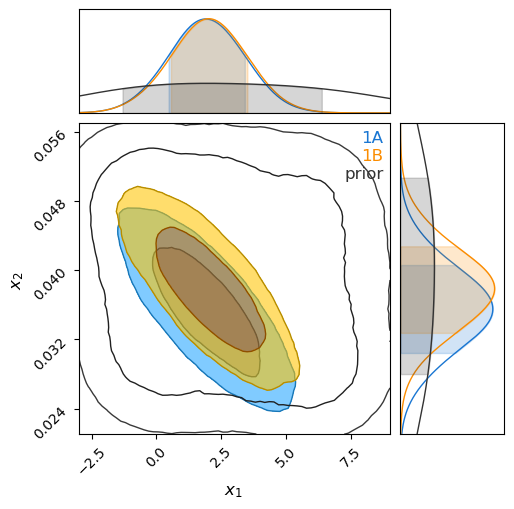

In [10]:
# Plot the chains, including the prior chain
# Hint: Use chainconsumer (You can look up the syntax in the session 1 notebook)
# Note: Each point in the MultiNest chain carries a corresponding weight. These need to be passed to chainconsumer as additional input
c = ChainConsumer()
parameters = ["$x_%s$"%(i+1) for i in range(nDims)]
c.add_chain(chain_1A[:,2:], weights = chain_1A[:,0], parameters=parameters, color = 'b', name = '1A', kde = 1.5)
c.add_chain(chain_1B[:,2:], weights = chain_1B[:,0], parameters=parameters, color = 'o', name = '1B', kde = 1.5)
c.add_chain(chain_prior_1[:,2:], weights = chain_prior_1[:,0], parameters=parameters, color = 'black', name = 'prior', kde = 1.5, shade = False)
c.plotter.plot(figsize=(5,5))
plt.show()

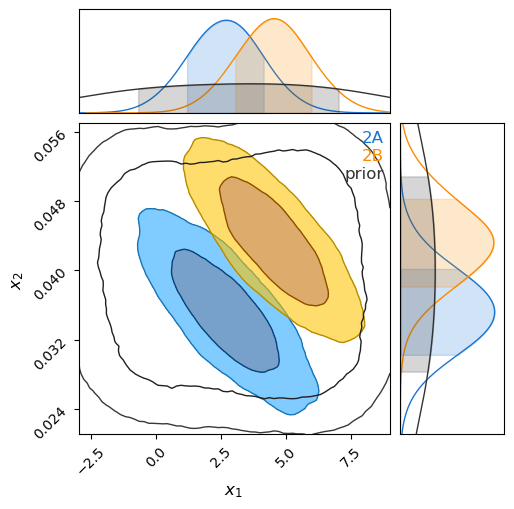

In [15]:
c = ChainConsumer()
parameters = ["$x_%s$"%(i+1) for i in range(nDims)]
c.add_chain(chain_2A[:,2:], weights = chain_2A[:,0], parameters=parameters, color = 'b', name = '2A', kde = 1.5)
c.add_chain(chain_2B[:,2:], weights = chain_2B[:,0], parameters=parameters, color = 'o', name = '2B', kde = 1.5)
c.add_chain(chain_prior_1[:,2:], weights = chain_prior_1[:,0], parameters=parameters, color = 'black', name = 'prior', kde = 1.5, shade = False)
c.plotter.plot(figsize=(5,5))
plt.show()

It is useful to plot the translated posterior distribution (TPD) to visualize the range of theory vectors in the chain. This requires us to translate each sample in the chain back into the data domain.

In [12]:
# For each chain, evaluate every point 
PPD_1A = np.array([model(ell, chain_1A[i,2], chain_1A[i,3]) for i in range(len(chain_1A))])
PPD_1B = np.array([model(ell, chain_1B[i,2], chain_1B[i,3]) for i in range(len(chain_1B))])

PPD_2A = np.array([model(ell, chain_2A[i,2], chain_2A[i,3]) for i in range(len(chain_2A))])
PPD_2B = np.array([model(ell, chain_2B[i,2], chain_2B[i,3]) for i in range(len(chain_2B))])

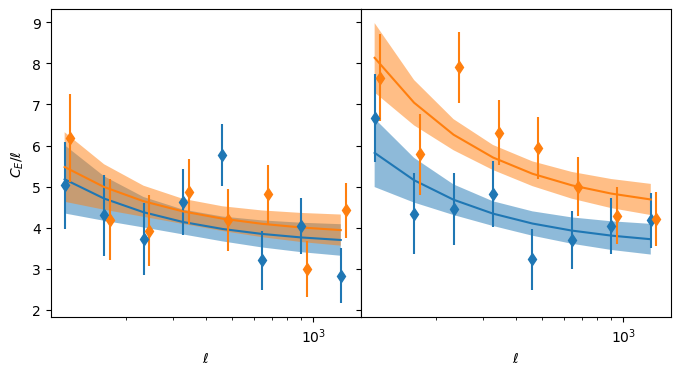

In [13]:
# Plot the data vector together with the mean and the standard deviation of the of the TPD. 
# Hint: Remember to take the weights into account when calculating the mean and standard deviation.
# Use plt.fill_between to plot the 1-sigma interval of the TPD

from statsmodels.stats.weightstats import DescrStatsW
weighted_stats_1A = DescrStatsW(PPD_1A, weights=chain_1A[:,0], ddof=0)
weighted_stats_1B = DescrStatsW(PPD_1B, weights=chain_1B[:,0], ddof=0)
weighted_stats_2A = DescrStatsW(PPD_2A, weights=chain_2A[:,0], ddof=0)
weighted_stats_2B = DescrStatsW(PPD_2B, weights=chain_2B[:,0], ddof=0)

fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)
ax[0].errorbar(ell, data_1A/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C0', fmt='d', label = 'data A')
ax[0].plot(ell, weighted_stats_1A.mean/ell*1e7)
ax[0].fill_between(ell, (weighted_stats_1A.mean-weighted_stats_1A.std)/ell*1e7, (weighted_stats_1A.mean+weighted_stats_1A.std)/ell*1e7, alpha = 0.5)

ax[0].errorbar(ell*1.05, data_1B/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C1', fmt='d', label = 'data A')
ax[0].plot(ell, weighted_stats_1B.mean/ell*1e7)
ax[0].fill_between(ell, (weighted_stats_1B.mean-weighted_stats_1B.std)/ell*1e7, (weighted_stats_1B.mean+weighted_stats_1B.std)/ell*1e7, alpha = 0.5)
ax[0].set_xscale('log')
ax[0].set_xlabel('$\ell$')
ax[0].set_ylabel('$C_E/\ell$')

ax[1].errorbar(ell, data_2A/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C0', fmt='d', label = 'data A')
ax[1].plot(ell, weighted_stats_2A.mean/ell*1e7)
ax[1].fill_between(ell, (weighted_stats_2A.mean-weighted_stats_2A.std)/ell*1e7, (weighted_stats_2A.mean+weighted_stats_2A.std)/ell*1e7, alpha = 0.5)

ax[1].errorbar(ell*1.05, data_2B/ell*1e7, yerr = np.sqrt(np.diag(covmat))/ell*1e7, color = 'C1', fmt='d', label = 'data A')
ax[1].plot(ell, weighted_stats_2B.mean/ell*1e7)
ax[1].fill_between(ell, (weighted_stats_2B.mean-weighted_stats_2B.std)/ell*1e7, (weighted_stats_2B.mean+weighted_stats_2B.std)/ell*1e7, alpha = 0.5)
ax[1].set_xscale('log')
ax[1].set_xlabel('$\ell$')
plt.subplots_adjust(wspace=0)
plt.show()

Now, we want to test if the two datasets are consistent with each other. To do so, we test the following hypotheses:
1) There exist two sets of parameters that each describe one dataset independently
2) There exists one single set of parameters that describes both datasets A and B at the same time

So far, our chains have tested hypothesis 2). Next, we will run chains testing hypothesis 1).

In [14]:
# Define the likelihood function for the combination of datasets A and B (hint: log-likelihoods are additive)
log_lkl_combined_1 = lambda cube, ndim, nparams: log_lkl(cube, ndim, nparams, data_1A) + log_lkl(cube, ndim, nparams, data_1B)
log_lkl_combined_2 = lambda cube, ndim, nparams: log_lkl(cube, ndim, nparams, data_2A) + log_lkl(cube, ndim, nparams, data_2B)

In [15]:
# Sample the combined likelihood with a single set of parameters
pymultinest.run(log_lkl_combined_1, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1_combined', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_combined_2, prior_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_2_combined', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -11.582864243232082      +/-   5.0278267349161208E-002
 Total Likelihood Evaluations:        95455
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -14.661006567075964      +/-   5.0282038361608952E-002
 Total Likelihood Evaluations:        87864
 Sampling finished. Exiting MultiNest


In [16]:
# Read the chains
combined_1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_1_combined')
combined_2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_2_combined')
chain_1_combined = combined_1.get_data()
chain_2_combined = combined_2.get_data()

  analysing data from out_multinest/chain_1_combined.txt
  analysing data from out_multinest/chain_2_combined.txt


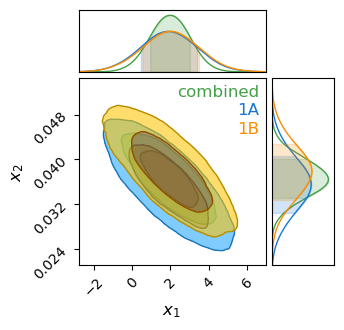

In [17]:
# Plot the chains
c = ChainConsumer()
parameters = ["$x_%s$"%(i+1) for i in range(nDims)]
c.add_chain(chain_1_combined[:,2:], weights = chain_1_combined[:,0], parameters=parameters, color = 'g', name = 'combined', kde = 1.5)
c.add_chain(chain_1A[:,2:], weights = chain_1A[:,0], parameters=parameters, color = 'b', name = '1A', kde = 1.5)
c.add_chain(chain_1B[:,2:], weights = chain_1B[:,0], parameters=parameters, color = 'o', name = '1B', kde = 1.5)
c.plotter.plot()
plt.show()

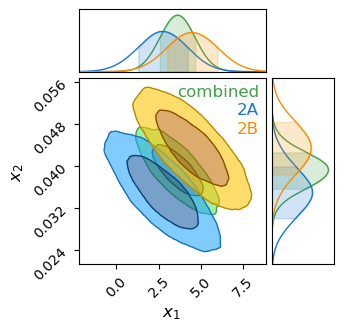

In [18]:
# Plot the chains
c = ChainConsumer()
parameters = ["$x_%s$"%(i+1) for i in range(nDims)]
c.add_chain(chain_2_combined[:,2:], weights = chain_2_combined[:,0], parameters=parameters, color = 'g', name = 'combined', kde = 1.5)
c.add_chain(chain_2A[:,2:], weights = chain_2A[:,0], parameters=parameters, color = 'b', name = '2A', kde = 1.5)
c.add_chain(chain_2B[:,2:], weights = chain_2B[:,0], parameters=parameters, color = 'o', name = '2B', kde = 1.5)
c.plotter.plot()
plt.show()


Now that we have run all chains we can make a model comparison to infer which of the two hypotheses is preferred by the data.
We calculate the Bayes Ratio:

$\log R = \log Z_{AB} - \log Z_{A} - \log Z_{B}$

In [19]:
# Calculate Bayes ratio 
# Hint: Use the get_stats() function of the pymultinest.Analyzer class to get the evidence. 
# Alternatively, you can take a look at the output files produced by MultiNest
Z_1A = A1.get_stats()['global evidence']
Z_1B = B1.get_stats()['global evidence']
Z_1_combined = combined_1.get_stats()['global evidence']
Z_2A = A2.get_stats()['global evidence']
Z_2B = B2.get_stats()['global evidence']
Z_2_combined = combined_2.get_stats()['global evidence']
logR_2 = Z_2_combined - Z_2A - Z_2B
logR_1 = Z_1_combined - Z_1A - Z_1B
print('1: logR = %.2f'%logR_1)
print('2: logR = %.2f'%logR_2)

1: logR = 2.26
2: logR = -2.93


Based on the Bayes ratios, in which case are the two datasets consistent with each other?

Now we want to investigate the impact of the prior volume on the Bayes ratio. 

In [20]:
# Define a few sets of priors. Take a look at the posterior plot that you produced earlier and define some new priors that are broader/narrower.
def prior_wide(cube, ndim, nparams):
    return(prior(cube, ndim, [[-10,20],[-0.02,0.12]]))
def prior_narrow_1(cube, ndim, nparams):
    return(prior(cube, ndim, [[-2,6],[0.024,0.05]]))
def prior_narrow_2(cube, ndim, nparams):
    return(prior(cube, ndim, [[-1,9.5],[0.022,0.055]]))

In [21]:
# Sample the likelihoods with different priors
# Individual likelihoods
pymultinest.run(log_lkl_1A, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_1A_wide', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_1B, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_1B_wide', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

pymultinest.run(log_lkl_2A, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_2A_wide', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_2B, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_2B_wide', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

# Combined likelihood
pymultinest.run(log_lkl_combined_1, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_1_combined_wide', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_combined_2, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_2_combined_wide', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

# Prior
pymultinest.run(log_lkl_prior, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_prior_wide_1', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_prior, prior_wide, nDims, resume = False, outputfiles_basename='out_multinest/chain_prior_wide_2', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -10.046110475372799      +/-   6.4458835959844252E-002
 Total Likelihood Evaluations:        99417
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -8.1404876329677869      +/-   6.4099777982813091E-002
 Total Likelihood Evaluations:       103886
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(

In [22]:
# Individual likelihoods
pymultinest.run(log_lkl_1A, prior_narrow_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1A_narrow', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_1B, prior_narrow_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1B_narrow', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

pymultinest.run(log_lkl_2A, prior_narrow_2, nDims, resume = False, outputfiles_basename='out_multinest/chain_2A_narrow', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_2B, prior_narrow_2, nDims, resume = False, outputfiles_basename='out_multinest/chain_2B_narrow', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

# Combined likelihood
pymultinest.run(log_lkl_combined_1, prior_narrow_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_1_combined_narrow', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_combined_2, prior_narrow_2, nDims, resume = False, outputfiles_basename='out_multinest/chain_2_combined_narrow', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)

# Prior
pymultinest.run(log_lkl_prior, prior_narrow_1, nDims, resume = False, outputfiles_basename='out_multinest/chain_prior_narrow_1', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)
pymultinest.run(log_lkl_prior, prior_narrow_2, nDims, resume = False, outputfiles_basename='out_multinest/chain_prior_narrow_2', n_live_points=nLive, sampling_efficiency=eff, evidence_tolerance=tol)


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -6.9719447429867696      +/-   3.4272156737899337E-002
 Total Likelihood Evaluations:        83031
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(ev)=  -5.0713701315296733      +/-   3.3325463373884319E-002
 Total Likelihood Evaluations:        84295
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =    2
 *****************************************************
 ln(

In [23]:
# Plot the new chains
def plots(dataset,suffix):
    chain_A = np.loadtxt('out_multinest/chain_%sA%s.txt'%(dataset,suffix))
    chain_B = np.loadtxt('out_multinest/chain_%sB%s.txt'%(dataset,suffix))
    chain_combined = np.loadtxt('out_multinest/chain_%s_combined%s.txt'%(dataset,suffix))
    chain_prior = np.loadtxt('out_multinest/chain_prior%s_%s.txt'%(suffix,dataset))
    
    # contains: weight, loglkl, params
    c = ChainConsumer()
    parameters = ["$x_%s$"%(i+1) for i in range(nDims)]
    c.add_chain(chain_A[:,2:], weights = chain_A[:,0], parameters=parameters, color = 'b', name = 'A', kde = 1.5)
    c.add_chain(chain_B[:,2:], weights = chain_B[:,0], parameters=parameters, color = 'o', name = 'B', kde = 1.5)
    c.add_chain(chain_combined[:,2:], weights = chain_combined[:,0], parameters=parameters, color = 'g', name = 'combined', kde = 1.5)
    c.add_chain(chain_prior[:,2:], weights = chain_prior[:,0], parameters=parameters, color = 'black', name = 'prior', kde = 1.5)
    c.plotter.plot()
    plt.show()


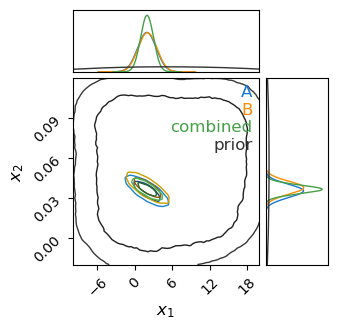

In [24]:
plots(1,'_wide')

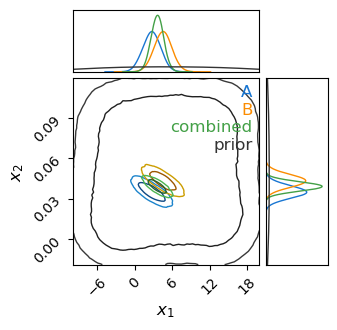

In [25]:
plots(2,'_wide')

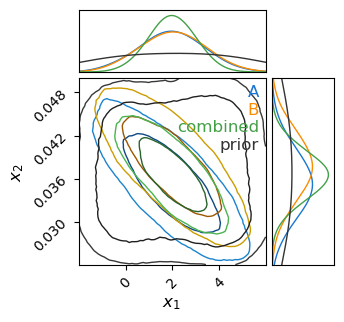

In [26]:
plots(1,'_narrow')

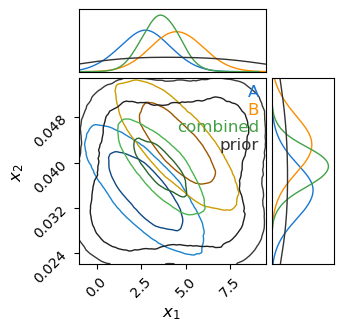

In [27]:
plots(2,'_narrow')

In [28]:
# Now calculate the Bayes ratio with new new prior. How do the values change for different prior ranges?
def Bayes_ratio(suffix):
    A1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_1A%s'%suffix)
    B1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_1B%s'%suffix)
    A2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_2A%s'%suffix)
    B2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_2B%s'%suffix)
    combined_1 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_1_combined%s'%suffix)
    combined_2 = pymultinest.Analyzer(n_params = 2, outputfiles_basename='out_multinest/chain_2_combined%s'%suffix)
    Z_1A = A1.get_stats()['global evidence']
    Z_1B = B1.get_stats()['global evidence']
    Z_1_combined = combined_1.get_stats()['global evidence']
    Z_2A = A2.get_stats()['global evidence']
    Z_2B = B2.get_stats()['global evidence']
    Z_2_combined = combined_2.get_stats()['global evidence']
    logR_2 = Z_2_combined - Z_2A - Z_2B
    logR_1 = Z_1_combined - Z_1A - Z_1B
    print('1: logR = %.2f'%logR_1)
    print('2: logR = %.2f'%logR_2)

In [29]:
Bayes_ratio('')

  analysing data from out_multinest/chain_1A.txt
  analysing data from out_multinest/chain_1B.txt
  analysing data from out_multinest/chain_2A.txt
  analysing data from out_multinest/chain_2B.txt
  analysing data from out_multinest/chain_1_combined.txt
  analysing data from out_multinest/chain_2_combined.txt
1: logR = 2.26
2: logR = -2.93


In [30]:
Bayes_ratio('_wide')

  analysing data from out_multinest/chain_1A_wide.txt
  analysing data from out_multinest/chain_1B_wide.txt
  analysing data from out_multinest/chain_2A_wide.txt
  analysing data from out_multinest/chain_2B_wide.txt
  analysing data from out_multinest/chain_1_combined_wide.txt
  analysing data from out_multinest/chain_2_combined_wide.txt
1: logR = 4.26
2: logR = -0.66


In [31]:
Bayes_ratio('_narrow')

  analysing data from out_multinest/chain_1A_narrow.txt
  analysing data from out_multinest/chain_1B_narrow.txt
  analysing data from out_multinest/chain_2A_narrow.txt
  analysing data from out_multinest/chain_2B_narrow.txt
  analysing data from out_multinest/chain_1_combined_narrow.txt
  analysing data from out_multinest/chain_2_combined_narrow.txt
1: logR = 1.27
2: logR = -3.14
